# Question 1

In this question we will:

- Implement and test a Histogram of Curvature Scale (HoCS) descriptor for an image.
- Extract the HoCS descriptors for the training images in our leaf dataset.
- Prepare a K-nearest-neighbours (KNN) classifier using the descriptors extracted from the training dataset.
- Extract the HoCS descriptors for the test images in our leaf dataset.
- Classify the descriptors from the test images into one of the three leaf shape classes using the KNN classifier prepared earlier.
- Reflect on the performance of the KNN classifier and your choices of parameters for the HoCS descriptors.

# Step 1:  Implement the Histogram of Curvature Scale

Write a function called HoCS that returns a histogram of curvature scale feature vector for a given region.  The inputs to your function should be:

- `B`: a binary that contains exactly one foreground connected component.
- `min_scale`: The samllest scale (circle radius) at which to calcluate curvature (must be a positive integer)
- `max_scale`: The largest scale (circle radius) at which to calculate curvature (must be an integer greater than `min_scale`)
- `increment`: The increment at which intermediate curvatures should be calculated (must be a positive integer)
- `num_bins`: The number of bins in the histogram of curvature for a single scale (must be a positive integer)

Your function should compute a histogram of curvature for each scale, starting at `min_scale` ending at (at most) `max_scale`, and for intermediate scales at increments of `increment`.  For example, if `min_scale`=4 and `max_scale`=20, and `increment`=3, then the function should compute a histogram of curvature for scales 4, 7, 10, 13, 16, and 19.  Each histogram at each scale should have `num_bins` bins.  Curvature must be computed using the normalized area integral invariant method described on Slide 39 of the Topic 9 lecture notes.  

Normalize each histogram at each scale.

To keep things straightforward, your function should only consider the main boundary of the input region and ignore the boundaries of holes in the region.

After computing the histogram of curvature at each of the specified scales, all of the histograms should be concatenated into a single one-dimensional array (feature vector) and then returned.

_Implementation hint:  You can calculate the normalized area integral invariant of each pixel efficiently using linear filtering.  You will find the function `skimage.morphology.disk()` function useful for designing the appropriate filter masks._

_Implementation hint:  Most of the heavy lifting here can be done with module functions from `skimage`, `numpy`, and `scipy`.  Many of the functions mentioned in class and in the notes will be useful.  One that we might not have covered, but will be very handy is `numpy.histogram()`.  When use use it, makes sure you specify both the `bins` and `range` optional arguments.  Also note that `numpy.histogram()` returns TWO things.  You only need the first one, so make sure you write your function call like this:_

`the_histogram, stuff_you_dont_need = np.histogram(...)`

In [2]:
import numpy as np
from scipy.ndimage import convolve, binary_fill_holes, binary_erosion
from skimage.morphology import disk
from skimage import measure

def _largest_component(B_bool):
    lbl, n = measure.label(B_bool, connectivity=2, return_num=True)
    if n <= 1:
        return B_bool
    regions = measure.regionprops(lbl)
    if not regions:
        return B_bool
    largest = max(regions, key=lambda r: r.area).label
    return (lbl == largest)

def _outer_boundary(B_bool):
    # Ignore hole boundaries by filling holes before boundary extraction
    B_main = _largest_component(B_bool)
    filled = binary_fill_holes(B_main)
    eroded = binary_erosion(filled)
    # Boundary is the place that was eroded from the filled image
    boundary = np.logical_and(filled, np.logical_not(eroded))
    return boundary, filled

def _normalized_area_integral(B, r, boundary_mask=None):
    """
    Compute κ(p, r) = area(C ∩ R)/area(C) for all pixels via convolution,
    optionally returning values only on the provided boundary mask.
    """
    if r < 1:
        raise ValueError("r must be >= 1")
    F = (B > 0).astype(np.float32)
    k = disk(int(r)).astype(np.float32)
    area = float(k.sum())

    # Convolution gives area(C ∩ R); divide by area(C) to normalize to [0,1]
    acc = convolve(F, k, mode='constant', cval=0.0) / area
    if boundary_mask is None:
        return acc
    return acc[boundary_mask]


def HoCS(B, min_scale, max_scale, increment, num_bins):
    '''
    Computes a histogram of curvature scale for the shape in the binary image B.  
    Boundary fragments due to holes are ignored.
    :param B: A binary image consisting of a single foreground connected component.
    :param min_scale: smallest scale to consider (minimum 1)
    :param max_scale: largest scale to consider (max_scale > min_scale)
    :param increment:  increment on which to compute scales between min_scale and max_scale
    :param num_bins: number of bins for the histogram at each scale
    :return: 1D array of histograms concatenated together in order of increasing scale.
    '''

    if min_scale < 1 or max_scale <= min_scale or increment < 1:
        raise ValueError("Invalid scale parameters")
    
    if num_bins < 1:
        raise ValueError("num_bins must be >= 1")
    
    radii = list(range(int(min_scale), int(max_scale) + 1, int(increment)))

    B_bool = (B > 0)
    boundary_mask, _ = _outer_boundary(B_bool)

    feats = []
    for r in radii:
        vals = _normalized_area_integral(B_bool, int(r), boundary_mask)
        hist, _ = np.histogram(vals, bins=int(num_bins), range=(0.0, 1.0))
        s = hist.sum()
        feats.append((hist / s).astype(np.float32) if s > 0 else hist.astype(np.float32))
    return np.concatenate(feats, axis=0).astype(np.float32)

# Step 2: Test your HoCS function.

Run your `HoCS()` function on `image_0001.png` from leaftraining directory.  Use `min_scale=5`, `max_scale=25`, `increment=10`, `num_bins=10`.  Plot the resulting feature vector as a bar graph.  Set the y-axis limits to be between 0.0 and 1.0.  You should get a result that matches the sample output in the assignment description.


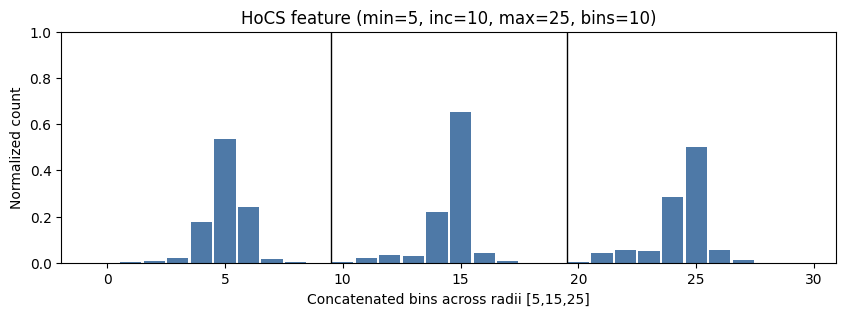

In [13]:
import skimage.io as io
import matplotlib.pyplot as plt

img = io.imread("leaftraining/image_0001.png")

fvec = HoCS(img, min_scale=5, max_scale=25, increment=10, num_bins=10)

# Plot as a bar graph
plt.figure(figsize=(10,3))
x = np.arange(len(fvec))
plt.bar(x, fvec, width=0.9, color="#4e79a7")
plt.ylim(0.0, 1.0)
plt.xlabel("Concatenated bins across radii [5,15,25]")
plt.ylabel("Normalized count")
# Visual separators between scales
nb = 10
for xi in [nb, 2*nb]:
    plt.axvline(xi-0.5, color='k', linewidth=1)
plt.title("HoCS feature (min=5, inc=10, max=25, bins=10)")
plt.show()

# Step 3: Calculate training features.

Use your function from Step 1 to compute the HoCS feature for each of the training images.  It is up to you to determine the parameters for the HoCS feature such as `min_scale`, `max_scale`, etc. to maximize the classification rate.  This will require some experimentation.  Slides 19-12 of Topic 12 lecture notes will be helpful here.  

Also generate the training labels here (a column-array of numbers indicating which descriptors belong to each class, e.g. use values 1,2,3 to indicate class 1, 2, and 3.).

In [43]:
import pandas as pd

# HoCS parameters
HOCS_MIN = 1
HOCS_MAX = 21
HOCS_INC = 5
HOCS_BINS = 25

files = pd.read_csv("leaftraining.csv", header=None)
training_files = files[0].tolist()

X_train = []
y_train = np.ones(30) # Per Assignment, first ten are grouped, then next ten, then final ten
y_train[10:20] = 2
y_train[20:30] = 3

for filename in training_files:
    img = io.imread(f"leaftraining/{filename}")
    feat = HoCS(img, HOCS_MIN, HOCS_MAX, HOCS_INC, HOCS_BINS)
    X_train.append(feat)

X_train = np.vstack(X_train).astype(np.float32)

print(X_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


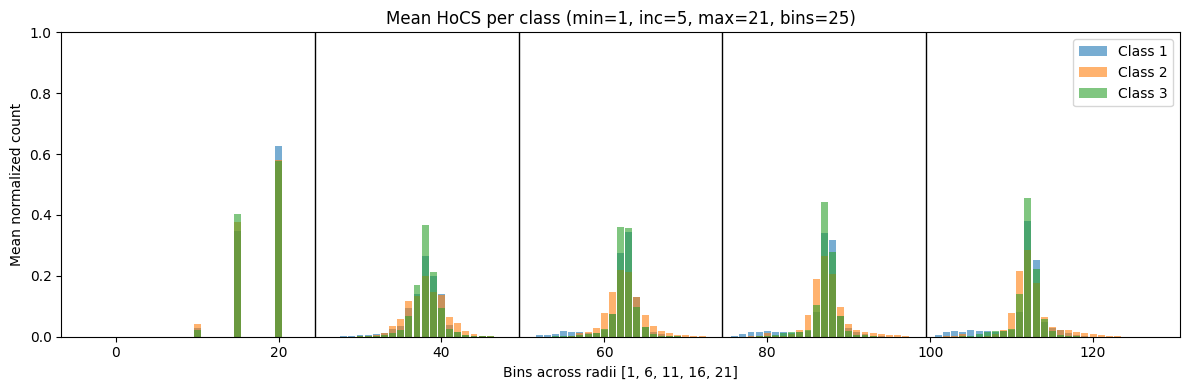

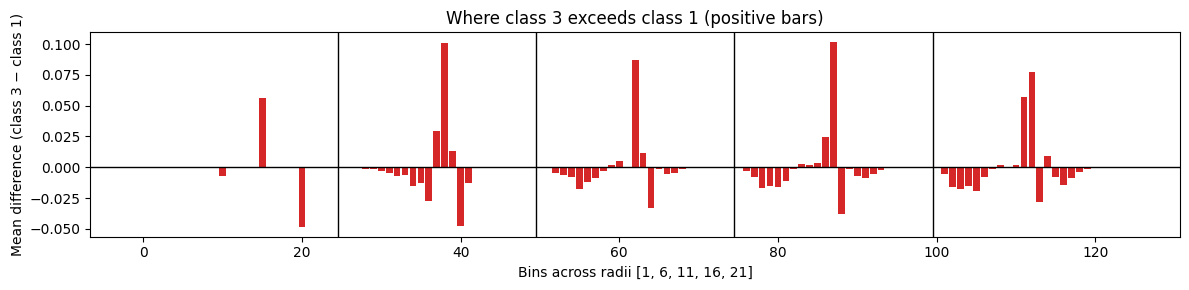

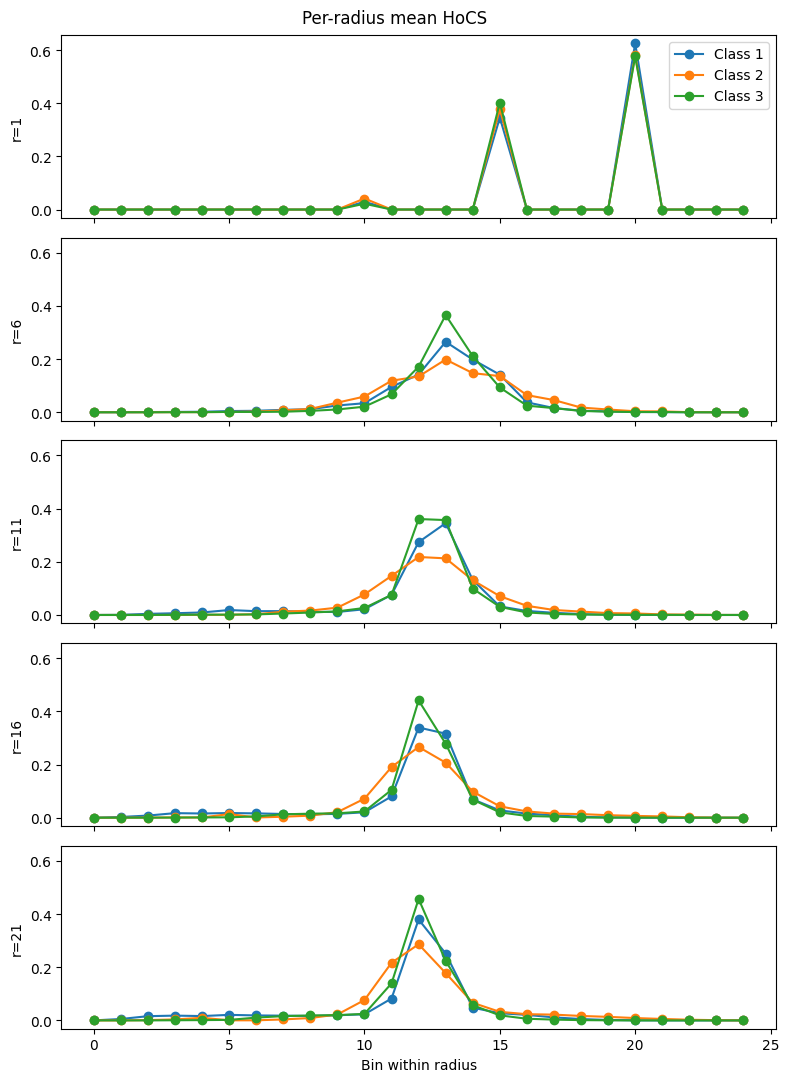

In [44]:
# Radii and dimensions
radii = list(range(HOCS_MIN, HOCS_MAX + 1, HOCS_INC))
n_scales = len(radii)
bins = HOCS_BINS

X = np.asarray(X_train, dtype=np.float32)
y = np.asarray(y_train, dtype=np.int32)

assert X.ndim == 2 and X.shape[1] == n_scales * bins, "Feature length must equal n_scales*bins"

# Class-wise means over samples (still concatenated across scales)
mean1 = X[y == 1].mean(axis=0)
mean2 = X[y == 2].mean(axis=0)
mean3 = X[y == 3].mean(axis=0)

# 1) Overlay of mean histograms per class (concatenated across all radii)
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
x = np.arange(n_scales * bins)

ax.bar(x, mean1, width=0.85, alpha=0.6, label="Class 1")
ax.bar(x, mean2, width=0.85, alpha=0.6, label="Class 2")
ax.bar(x, mean3, width=0.85, alpha=0.6, label="Class 3")

# Scale separators
for k in range(1, n_scales):
    ax.axvline(k * bins - 0.5, color='k', linewidth=1)

ax.set_ylim(0.0, 1.0)
ax.set_xlabel(f"Bins across radii {radii}")
ax.set_ylabel("Mean normalized count")
ax.set_title(f"Mean HoCS per class (min={HOCS_MIN}, inc={HOCS_INC}, max={HOCS_MAX}, bins={HOCS_BINS})")
ax.legend()
fig.tight_layout()
plt.show()

# 2) Targeted difference: Class 3 minus Class 1 (where positive bins favor class 3)
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
diff31 = mean3 - mean1
ax.bar(x, diff31, width=0.85, color="#d62728")
for k in range(1, n_scales):
    ax.axvline(k * bins - 0.5, color='k', linewidth=1)
ax.axhline(0.0, color='black', linewidth=1)
ax.set_xlabel(f"Bins across radii {radii}")
ax.set_ylabel("Mean difference (class 3 − class 1)")
ax.set_title("Where class 3 exceeds class 1 (positive bars)")
fig.tight_layout()
plt.show()

# 3) Per‑radius small multiples to see separation at each scale
fig, axes = plt.subplots(n_scales, 1, figsize=(8, 2.2 * n_scales), sharex=True, sharey=True)
if n_scales == 1:
    axes = [axes]
for s in range(n_scales):
    a = axes[s]
    idx = slice(s * bins, (s + 1) * bins)
    bx = np.arange(bins)
    a.plot(bx, mean1[idx], "-o", label="Class 1")
    a.plot(bx, mean2[idx], "-o", label="Class 2")
    a.plot(bx, mean3[idx], "-o", label="Class 3")
    a.set_ylabel(f"r={radii[s]}")
axes[-1].set_xlabel("Bin within radius")
axes[0].legend(loc="upper right")
fig.suptitle("Per-radius mean HoCS")
fig.tight_layout()
plt.show()

# Step 4: Train the KNN classifier using the feature vectors from the training images.

You have another opportunity here to optimize parameters.  You can experiment with the options for the KNN classifier (in partiuclar n_neighbors) to try to obtain better classification rates.  But you won't really be able to do this until after step 6, so just use default parameters to start with. 

Hint: The steps in this notebook are broken up the way they are so that you can adjust the parameters of training the classifier and then go and perform the classfication without having to re-run the calculation of the features in steps 3 and 5.  You can adjust the parameters here in step 4, and then go and re-run the test set in Step 6 without running step 5 over again -- which is good because step 5 will take a while to run.  Of course you will have to recalculate the features each time you restart PyCharm or the Jupyter Notebook server.

In [37]:
from sklearn.neighbors import KNeighborsClassifier

# Default to start but setting up for tuning later if needed
K = 3          # n_neighbors
W = "distance"  # weights
METRIC = "minkowski"

knn = KNeighborsClassifier(n_neighbors=K, weights=W, metric=METRIC)
knn.fit(X_train, y_train)

,n_neighbors,3
,weights,'distance'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


# Step 5: Calculate the testing features.

Compute the HoCS features for all of the testing images using the filenames in `leaftesting.csv`.  Use the same HoCS parameters you did in Step 3.  Also generate class labels for the testing image descriptors.

In [27]:
files = pd.read_csv("leaftesting.csv", header=None)
test_files = files[0].tolist()

X_test = []
y_test = np.ones(50+27+52, dtype=np.uint8)
y_test[50:50+27] = 2
y_test[50+27:50+27+52] = 3

for filename in test_files:
    img = io.imread(f"leaftesting/{filename}")
    feat = HoCS(img, HOCS_MIN, HOCS_MAX, HOCS_INC, HOCS_BINS)
    X_test.append(feat)

X_test = np.vstack(X_test).astype(np.float32)


# Step 6: Classfiy the testing features.

Classify the descriptors you generated from the test images using the KNN classifier you created in Step 4.

Determine the classification rate and the confusion matrix by comparing the results of the classifier to the true class labels for each image.  

Print out the filenames of incorrectly classified images.

Print the confusion matrix (you don't have to print the row/column indicies as in the example in the assignment description), just the rows and columns of the matrix itself.   Confusion matrix is explained in the background section of the assignment PDF document.

Print the correct classification rate.  Classification rate is explained in the Topic 12 notes and in the background section of the assignment PDF document.

It should be very easy to get a classficiation rate more than 90%; with well-chosen parameters for your HoCS features and the KNN classifier you should be able to get as much as 95%.

In [39]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Basic sanity checks (fail fast if something is inconsistent)
assert X_train.shape[1] == X_test.shape[1], "Train/Test feature dimensions mismatch"
assert len(test_files) == X_test.shape[0] == y_test.shape[0], "Test sample count, filenames, and labels must match"

# Predict with existing KNN
y_pred = knn.predict(X_test)

# Metrics
labels = [1, 2, 3]
cm = confusion_matrix(y_test, y_pred, labels=labels)
acc = accuracy_score(y_test, y_pred)

print("Confusion matrix (rows=true, cols=pred):")
print(cm)
print("\nAccuracy: {:.2f}%".format(acc * 100))

print("\nPer-class report:")
print(classification_report(y_test, y_pred, labels=labels, zero_division=0))

print("\nMisclassified files:")
for fn, yt, yp in zip(test_files, y_test, y_pred):
    if yt != yp:
        print(f"  {fn} -> pred={yp}, true={yt}")


Confusion matrix (rows=true, cols=pred):
[[50  0  0]
 [ 0 27  0]
 [ 8  3 41]]

Accuracy: 91.47%

Per-class report:
              precision    recall  f1-score   support

           1       0.86      1.00      0.93        50
           2       0.90      1.00      0.95        27
           3       1.00      0.79      0.88        52

    accuracy                           0.91       129
   macro avg       0.92      0.93      0.92       129
weighted avg       0.93      0.91      0.91       129


Misclassified files:
  image_0127.png -> pred=1.0, true=3
  image_0134.png -> pred=1.0, true=3
  image_0140.png -> pred=2.0, true=3
  image_0144.png -> pred=1.0, true=3
  image_0145.png -> pred=1.0, true=3
  image_0153.png -> pred=1.0, true=3
  image_0155.png -> pred=1.0, true=3
  image_0173.png -> pred=2.0, true=3
  image_0177.png -> pred=1.0, true=3
  image_0185.png -> pred=2.0, true=3
  image_0186.png -> pred=1.0, true=3


# Step 7: Reflections

Answer the following questions right here in this block:

- Discuss your HoCS parameters and how you arrived at them.  Why did you choose the scales and number of histogram bins that you did?  Are there other values that work just as well?   Likely you tested other HoCS parameters that resulted in worse performance before finding the ones that worked best -- what were some of them and why do you think the performance was worse?

	_Your answer:_

- Discuss your choice of KNN classifier parameters and how you arrived at them (think about the same types of questions as in the previous point).

	_Your answer:_

- Discuss the misclassified images.  Were there any classes that were particularly difficult to distinguish?  Is there anything unusual about any of the misclassified images that would cuase them to be misclassified?  If so, explain

	_Your answer:_
